# Generate the Distance Matrices
For each name in the stock watchers data, we will compute the distance to each name in the propublica data (subsetted to House/Senate). First we will clean up the names a bit.

In [202]:
import os
from dotenv import load_dotenv
import sys
import pandas as pd
import jellyfish
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../")

from resources.bitio_helper import download_dataset

load_dotenv()
PG_STRING = os.getenv("BITIO_PG_STRING")
USERNAME = os.getenv("BITIO_USERNAME")

## Data Download and Preprocessing

In [3]:
# Download from bit.io
propublica_data = download_dataset('"bitdotio/congress-names"."propublica_names"', PG_STRING)
stockwatchers_data = download_dataset('"bitdotio/congress-names"."stock_watchers_names"', PG_STRING)

In [104]:
# some basic cleaning
## remove missing name components from propub data
propublica_data["name_clean"] = propublica_data["name"].str.replace(" nothing", "")

## remove honorifics, titles, etc. from SW data
replacements = '|'.join(['^Mr. ', '^Mrs. ', '^Hon. ', '^None ', ' Honorable'])
stockwatchers_data["name_clean"] = stockwatchers_data["name"].str.replace(replacements, "", regex=True)

In [105]:
prp_house = propublica_data.loc[propublica_data.chamber == "house", ["name_clean"]].rename(columns={"name_clean":"name"})
sw_house = stockwatchers_data.loc[stockwatchers_data.chamber == "house", ["name_clean"]].rename(columns={"name_clean":"name"})

prp_senate = propublica_data.loc[propublica_data.chamber == "senate", ["name_clean"]].rename(columns={"name_clean":"name"})
sw_senate = stockwatchers_data.loc[stockwatchers_data.chamber == "senate", ["name_clean"]].rename(columns={"name_clean":"name"})


In [116]:
prp_names_house = list(prp_house["name"])
prp_names_senate = list(prp_senate["name"])

## Calculate Levenshtein Distances

In [119]:
# helper function for getting levenshtein distance across columns
def normalized_ld(name, candidate):
    ld = jellyfish.levenshtein_distance(name, candidate)
    maxlength = max([len(name), len(candidate)])
    normalized_ld = 1-(ld/maxlength)
    return normalized_ld

def ls(name, candidates):
    """Calculate the normalized levenshtein distance between a name
    and a list of candidate names"""
    return list(map(lambda x: normalized_ld(name, x), candidates))

def make_ls_matrix(names, candidates):
    """Given a dataframe of names and a list of candidates, return a
    dataframe with names as rows and candidates as columns with
    scores as values, along with columns for best match and best
    match score"""
    normalized_lds = names.apply(lambda x: ls(x["name"], candidates), axis=1, result_type="expand")
    normalized_lds.columns = candidates
    normalized_lds.insert(loc=0, column = "stock_watchers_name", value=names["name"])
    normalized_lds.insert(loc=1, column="closest_match", value=normalized_lds.iloc[:,1:].idxmax(axis=1))
    normalized_lds.insert(loc=2, column="closest_match_score", value=normalized_lds.iloc[:,2:].max(axis=1))

    return normalized_lds.sort_values("closest_match_score", axis=0)


In [120]:
house_mat = make_ls_matrix(names=sw_house, candidates=prp_names_house)
senate_mat = make_ls_matrix(names = sw_senate, candidates=prp_names_senate)

### Get Top Matches for Visualization

In [183]:
def top_n_matches(member, n=5):
    """Takes a row for the matching matrix generated above. Returns a new
    matrix with the top N members and their scores."""
    top_matches = list(member[3:].rank().sort_values().index.values[-n:])
    match_sub = member.loc[top_matches]
    return match_sub


In [191]:
list(top_n_matches(senate_mat.iloc[1], 7).index.values)

prp_senate_sub = ['Mitch McConnell', 'Michael Bennet', 'Shelley Moore Capito',
                  'Richard M. Burr', 'John Hickenlooper']
sw_senate_sub = ['A. Mitchell Mcconnell, Jr.', 'Michael F Bennet', 'Shelley M Capito',
                 'Richard M Burr', 'John W Hickenlooper']

In [194]:
senate_sub = (senate_mat.loc[senate_mat["stock_watchers_name"].isin(sw_senate_sub), ["stock_watchers_name"]+prp_senate_sub]
                .set_index("stock_watchers_name"))
senate_sub

,Mitch McConnell,Michael Bennet,Shelley Moore Capito,Richard M. Burr,John Hickenlooper
stock_watchers_name,,,,,
"A. Mitchell Mcconnell, Jr.",0.538462,0.346154,0.230769,0.230769,0.230769
Shelley M Capito,0.125000,0.187500,0.800000,0.125000,0.058824
Michael F Bennet,0.375000,0.875000,0.200000,0.375000,0.117647
John W Hickenlooper,0.157895,0.210526,0.100000,0.105263,0.894737
Richard M Burr,0.200000,0.357143,0.150000,0.933333,0.058824


(<matplotlib.image.AxesImage at 0x1427d67c0>,
 <matplotlib.colorbar.Colorbar at 0x142d67310>)

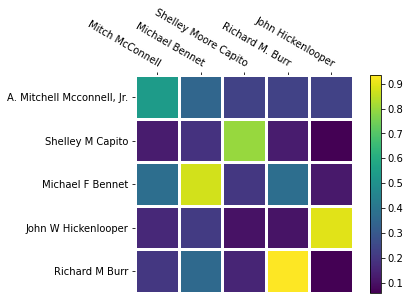

In [203]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

heatmap(senate_sub.values, senate_sub.index.values, senate_sub.columns.values)

In [196]:
senate_sub.index.values

array(['A. Mitchell Mcconnell, Jr.', 'Shelley M Capito',
       'Michael F Bennet', 'John W Hickenlooper', 'Richard M Burr'],
      dtype=object)